In [34]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [35]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [36]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Video_Games", split="full", trust_remote_code=True)

title 
description
average_rating
price
store
subtitle

In [37]:
dataset[0]

{'main_category': 'Video Games',
 'title': 'Dash 8-300 Professional Add-On',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Features Dash 8-300 and 8-Q300 ('Q' rollout livery)",
  'Airlines - US Airways, South African Express, Bahamasair, Augsburg Airways, Lufthansa Cityline, British Airways (Union Jack), British European, FlyBe, Intersky, Wideroe, Iberia, Tyrolean, QantasLink, BWIA',
  'Airports include - London City, Frankfurt, Milan and Amsterdam Schipol',
  'Includes PSS PanelConfig and LoadEdit tools'],
 'description': ['The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flig

In [38]:
type(dataset)

datasets.arrow_dataset.Dataset

In [39]:
i = 0
for data in dataset:
    if data["price"] != 'None':
        print(data)
        print(f"{'='*20}\n")
    i = i + 1
    if i  == 5:
        break

{'main_category': 'Video Games', 'title': 'NBA 2K17 - Early Tip Off Edition - PlayStation 4', 'average_rating': 4.3, 'rating_number': 223, 'features': ['The #1 rated NBA video game simulation series for the last 15 years (Metacritic).', 'The #1 selling NBA video game simulation series for the last 9 years (NPD).', 'Over 85 awards and nominations since the launch of PlayStation 4 & Xbox One.', 'BEST IN CLASS GAMEPLAY - 2K puts shot making in your hands like never before. Advanced Skill Shooting gives you complete control over the power and aim of your perimeter shots as well as your ability to finish inside the paint.', 'THE PRELUDE - Begin your MyCAREER on one of 10 licensed collegiate programs, available for free download one week prior to launch!', 'MyCAREER - It’s all-new and all about basketball in 2K17 – and you’re in control. Your on-court performance and career decisions lead to different outcomes as you determine your path through an immersive new narrative, featuring Michael B

# Data Preparation

In [40]:
def is_not_none(row):
    columns = ['title', 'description', 'average_rating', 'price', 'store', 'features']
    for col in columns:
        value = row[col]
        if isinstance(value, list):
            if not value:  
                return False
        elif value == 'None' or value == None:
            return False
    return True

filtered_dataset = dataset.filter(is_not_none)

In [41]:
from datasets import Dataset
import pandas as pd 
import re

def clean_price(price):
    if price is None or str(price) == 'None':
        return None
    try:
        cleaned = re.findall(r'\d+\.?\d*', str(price))
        return float(cleaned[0]) if cleaned else None
    except (ValueError, IndexError):
        return None
        
def process_row(row):
    feature = row['features']
    desc = row['description']
    store = row['store']
    avg_rating = row['average_rating']
    title = row['title']
    price = row['price']
    
    desc_str = ' '.join(desc) if isinstance(desc, list) else str(desc)
    store_str = ' '.join(store) if isinstance(store, list) else str(store)

    feature_str = ' '.join(feature) if isinstance(feature, list) else str(feature)
    avg_rating_str = ' '.join(avg_rating) if isinstance(avg_rating, list) else str(avg_rating)
    title_str = ' '.join(title) if isinstance(title, list) else str(title)
    
    new_desc = f"""How much does this cost to the nearest dollar?
    
title: {title_str}
features: {feature_str}
description: {desc_str}
store: {store_str}
avg_rating: {avg_rating_str}

Price is ${clean_price(price)}
    """.strip()
    
    return {
        'description': new_desc,
        'price': clean_price(price)
    }

def filter_and_map(row):
    result = process_row(row)
    return result is not None

processed_dataset = filtered_dataset.map(process_row, remove_columns=dataset.column_names)
filtered_dataset = processed_dataset.filter(lambda x: x is not None)
print(filtered_dataset.to_pandas())

Map:   0%|          | 0/38045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/38045 [00:00<?, ? examples/s]

                                             description  price
0      How much does this cost to the nearest dollar?...  58.00
1      How much does this cost to the nearest dollar?...  33.98
2      How much does this cost to the nearest dollar?...  20.95
3      How much does this cost to the nearest dollar?...   4.97
4      How much does this cost to the nearest dollar?...  13.99
...                                                  ...    ...
38040  How much does this cost to the nearest dollar?...  45.99
38041  How much does this cost to the nearest dollar?...   9.99
38042  How much does this cost to the nearest dollar?...  81.88
38043  How much does this cost to the nearest dollar?...   6.10
38044  How much does this cost to the nearest dollar?...  31.04

[38045 rows x 2 columns]


In [42]:
print(filtered_dataset[0]["description"])

How much does this cost to the nearest dollar?
    
title: NBA 2K17 - Early Tip Off Edition - PlayStation 4
features: The #1 rated NBA video game simulation series for the last 15 years (Metacritic). The #1 selling NBA video game simulation series for the last 9 years (NPD). Over 85 awards and nominations since the launch of PlayStation 4 & Xbox One. BEST IN CLASS GAMEPLAY - 2K puts shot making in your hands like never before. Advanced Skill Shooting gives you complete control over the power and aim of your perimeter shots as well as your ability to finish inside the paint. THE PRELUDE - Begin your MyCAREER on one of 10 licensed collegiate programs, available for free download one week prior to launch! MyCAREER - It’s all-new and all about basketball in 2K17 – and you’re in control. Your on-court performance and career decisions lead to different outcomes as you determine your path through an immersive new narrative, featuring Michael B. Jordan. Additionally, new player controls give y

In [43]:
tess = filtered_dataset.to_pandas()
tess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38045 entries, 0 to 38044
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  38045 non-null  object 
 1   price        38045 non-null  float64
dtypes: float64(1), object(1)
memory usage: 594.6+ KB


# EDA

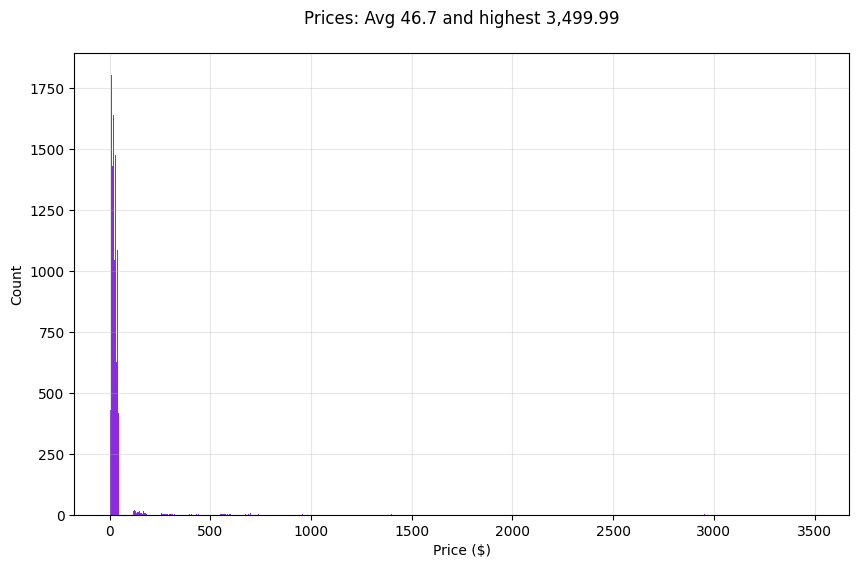

In [44]:
import matplotlib.pyplot as plt

# Ambil DataFrame
items = filtered_dataset.to_pandas()

# Buat histogram
plt.figure(figsize=(10, 6))
plt.title(f"Prices: Avg {items['price'].mean():,.1f} and highest {items['price'].max():,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(items['price'], rwidth=0.5, color="blueviolet", bins=range(0, int(items['price'].max())))
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
Q1 = items['price'].quantile(0.25)
Q3 = items['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = items[(items['price'] < Q1 - 1.5 * IQR) | (items['price'] > Q3 + 1.5 * IQR)]
print(f"Outliers {len(outliers)}:", outliers[['description', 'price']])

Outliers 3870:                                              description   price
5      How much does this cost to the nearest dollar?...  182.93
26     How much does this cost to the nearest dollar?...  185.00
41     How much does this cost to the nearest dollar?...  149.00
52     How much does this cost to the nearest dollar?...  144.91
59     How much does this cost to the nearest dollar?...  185.00
...                                                  ...     ...
37991  How much does this cost to the nearest dollar?...   93.65
38003  How much does this cost to the nearest dollar?...  166.35
38012  How much does this cost to the nearest dollar?...   99.99
38026  How much does this cost to the nearest dollar?...  184.26
38037  How much does this cost to the nearest dollar?...  299.00

[3870 rows x 2 columns]


In [46]:
items['desc_length'] = items['description'].apply(lambda x: len(str(x).split()))
correlation = items['desc_length'].corr(items['price'])
print("Korelasi panjang deskripsi dan harga:", correlation)

Korelasi panjang deskripsi dan harga: 0.03422515857749483


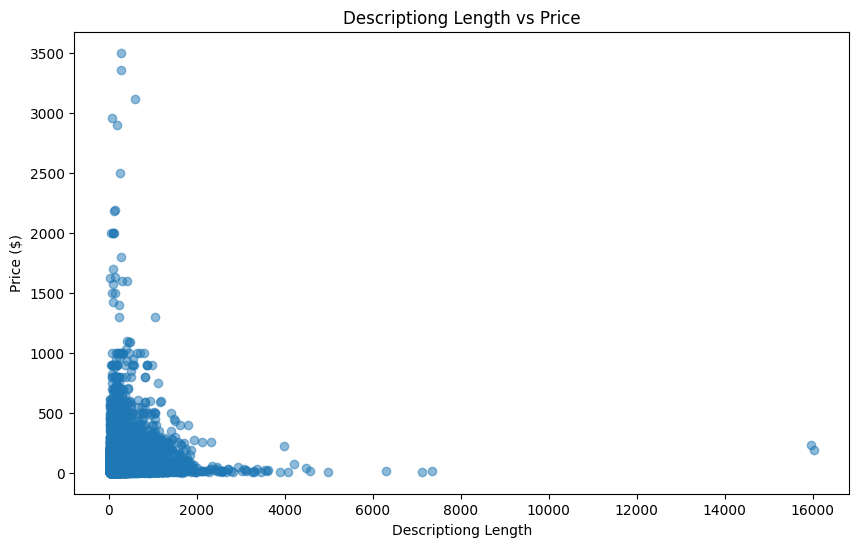

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(items['desc_length'], items['price'], alpha=0.5)
plt.title('Descriptiong Length vs Price')
plt.xlabel('Descriptiong Length')
plt.ylabel('Price ($)')
plt.show()

In [49]:
train_test_split = filtered_dataset.train_test_split(test_size=0.2, seed=42)  # seed untuk reproduktibilitas

# Buat DatasetDict
dataset_dict = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

# Unggah ke Hugging Face
dataset_dict.push_to_hub("baihaqiyazid/pricer-data-amazon-video-games")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/426 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/baihaqiyazid/pricer-data-amazon-video-games/commit/b589a78fb66a1427d6f3240cb5d3c596f22c1d43', commit_message='Upload dataset', commit_description='', oid='b589a78fb66a1427d6f3240cb5d3c596f22c1d43', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/baihaqiyazid/pricer-data-amazon-video-games', endpoint='https://huggingface.co', repo_type='dataset', repo_id='baihaqiyazid/pricer-data-amazon-video-games'), pr_revision=None, pr_num=None)